## 데이터 시각화
### 시각화를 위해 필요한 데이터 추출
>   - 위도/경도 데이터

In [1]:
# geocoder 2.0 API로 위도, 경도 데이터 찾기
import requests
from tqdm import tqdm
import pandas as pd
import pymysql

#DB 접속 정보
with open("./db.config",'r') as f:
    db_data = f.read()
db_data = eval(db_data)

#DB 접속
_host = db_data['DB_HOST']
_user = db_data['DB_USER']
_password = db_data['DB_PASSWORD']
_name = db_data['DB_NAME']

con = pymysql.connect(host=f'{_host}', user=f'{_user}', password=f'{_password}', db=f'{_name}', charset='utf8')
cur = con.cursor()

tmp = ''
data = []
failed = []

lh_df = pd.read_sql_query('select * from allLh', con=con)
ansim_df = pd.read_sql_query('select * from ansim', con=con)


#API 키 추가 필요합니다. @KKH
for idx, row in tqdm(lh_df.iterrows()):
    apiurl = "https://api.vworld.kr/req/address?"
    params = {
        "service": "address",
        "request": "getcoord",
        "crs": "epsg:4326",
        "address": row['adresWay'],
        "format": "json",
        "type": "road",
        "key": "[API-KEY]"
    }
    response = requests.get(apiurl, params=params)
    if response.status_code == 200:
        tmp = response.json()
        try:
            data.append(tmp['response']['result']['point'])
        except Exception as e:
            params["type"] = "parcel"
            response = requests.get(apiurl, params=params)
            if response.status_code == 200:
                tmp = response.json()
                try:
                    data.append(tmp['response']['result']['point'])
                except Exception as e:
                    failed.append(idx)

#api 키 추가 필요합니다. @KKH
for idx, row in tqdm(ansim_df.iterrows()):
    apiurl = "https://api.vworld.kr/req/address?"
    params = {
        "service": "address",
        "request": "getcoord",
        "crs": "epsg:4326",
        "address": row['adresWay'],
        "format": "json",
        "type": "road",
        "key": "[API-KEY]"
    }
    response = requests.get(apiurl, params=params)
    if response.status_code == 200:
        tmp = response.json()
        try:
            data.append(tmp['response']['result']['point'])
        except Exception as e:
            params["type"] = "parcel"
            response = requests.get(apiurl, params=params)
            if response.status_code == 200:
                tmp = response.json()
                try:
                    data.append(tmp['response']['result']['point'])
                except Exception as e:
                    failed.append(idx)
                    
# 위도 경도 데이터 저장
for i in range(len(lh_df)):
    ansim_df.loc[i, 'x'] = data[i]['x']
    ansim_df.loc[i, 'y'] = data[i]['y']

ansim_df.loc[14,'x']='126.8982447'
ansim_df.loc[14,'y']='37.5251247'
ansim_df.loc[41,'x']='126.9167221'
ansim_df.loc[41,'y']='37.5507977'
ansim_df.loc[27,'x']='126.837949'
ansim_df.loc[27,'y']='37.5406894'

/tmp/ipykernel_31146/322590594.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lh_df = pd.read_sql_query('select * from allLh', con=con)
/tmp/ipykernel_31146/322590594.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ansim_df = pd.read_sql_query('select * from ansim', con=con)
15it [00:02,  5.89it/s]


KeyboardInterrupt: 

In [2]:
# CSV 파일 저장
lh_df.to_csv('lh_df.csv', index=False)
ansim_df.to_csv('ansim_df.csv', index=False)

### 청년 주택 정보 제공

In [3]:
where_lh = pd.read_csv("./data/lh_df.csv")
where_ansim = pd.read_csv("./data/ansim_df.csv")
#where_lh = lh_df.copy()``
#where_ansim = ansim_df.copy()

In [4]:
import folium
where_hang = where_lh[where_lh['kindRental'] != '매입임대']
where_all = pd.concat([where_hang,where_ansim])
popmap = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles="cartodb positron")
target =  where_all[['x', 'y', 'kindRental','adresWay','adresGu','kindHouse','totArea','scaleTot']].copy()
target['color'] =target.kindRental.apply(lambda x : 'red' if x =="매입임대" else ('blue' if x == "행복주택"  else 'orange')   )
popmap = folium.Map(location=[37.5502, 126.982], zoom_start=11)
for idx, row in target.iterrows():
    folium.Marker([row.y, row.x],
                  popup=f"""<div style="white-space: nowrap;">주소: {row.adresWay}<br>주택 종류: {row.kindHouse}<br>면적: {row.totArea}<br>세대수: {row.scaleTot}</div>""",              
                  icon=folium.Icon(color=row.color, icon='star')
                 ).add_to(popmap)

In [5]:
#지도 출력
popmap

### 비트맵(choropleth)으로 청년 주택 수 출력

In [6]:
import sqlalchemy

from urllib import parse
with open("./db.config",'r') as f:
    db_data = f.read()
db_data = eval(db_data)
_host = db_data['DB_HOST']
_user = db_data['DB_USER']
_password = db_data['DB_PASSWORD']
_name = db_data['DB_NAME']
_port = 3306
_password = parse.quote_plus(_password)
engine = sqlalchemy.create_engine(f"mysql://{_user}:{_password}@{_host}:{_port}/{_name}")

In [7]:
# 각 구별로 중심점 찾기
import folium
import requests
import json
geo_str = requests.get("https://t1.daumcdn.net/cfile/tistory/272C224C58B4BD540B").json()

from shapely.geometry import Polygon, MultiPolygon
nametoloc = {}
for feature in geo_str['features']:
    geometry = feature['geometry']
    properties = feature['properties']
    
    if geometry['type'] == 'Polygon':
        polygon = Polygon(geometry['coordinates'][0])
        center = polygon.centroid.coords[0]
    elif geometry['type'] == 'MultiPolygon':
        polygon = MultiPolygon([Polygon(coord[0]) for coord in geometry['coordinates']])
        center = polygon.centroid.coords[0]
    else:
        continue
    
    # 중심점을 지도에 표시
    nametoloc[properties['name']] = (center[1],center[0])

In [8]:
all_apart_map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles="cartodb positron")
pd.read_sql("select * from apart_allRentView",con=engine)['자치구'].sort_values().tolist()


apart_df = pd.read_sql("""SELECT A.adresGu, A.num AS number FROM (SELECT A.adresGu,A.AB + IFNULL(B.AB,0) AS num  FROM (SELECT adresGu, COUNT(*) AS AB 
            FROM allLh GROUP BY adresGu ORDER BY adresGu) A LEFT JOIN (SELECT adresGu, IFNULL(COUNT(*),0) 
            AS AB FROM ansim GROUP BY adresGu ORDER BY adresGu) B ON A.adresGu = B.adresGu) A""", con=engine)
folium.Choropleth(geo_str, 
                  data = apart_df, 
                  columns=['adresGu', 'number'],
                  fill_color= "PuRd",
                  key_on = 'feature.id').add_to(all_apart_map)
for idx, row in apart_df.iterrows():
    adres= row['adresGu']; numb = row['number']
    icon1 = folium.DivIcon(html=f"<div style='font-size: 10pt;font-weight:bold;width:200px'>{adres}<br>({numb}개)</div>")
    folium.Marker(location=nametoloc[row['adresGu']],icon=icon1).add_to(all_apart_map)

In [9]:
#주택 수 출력
all_apart_map

*matplotlib 한글 폰트 설정*

    1. font 설치: sudo apt-get install fonts-nanum
    2. 캐시 디렉터리 찾기
    3. 캐시 제거: rm -r [2번에서 찾은 캐시디렉터리 path]
    4. Nanum Gothic을 폰트 설정





In [10]:
import matplotlib

#matplot 캐시디렉토리 찾기
matplotlib.get_cachedir()

'/home/david/.cache/matplotlib'

In [13]:
# 나눔고딕 폰트 설정
from matplotlib import rc
rc('font',family='NanumGothic')

Text(0.5, 1.0, '호감지수')

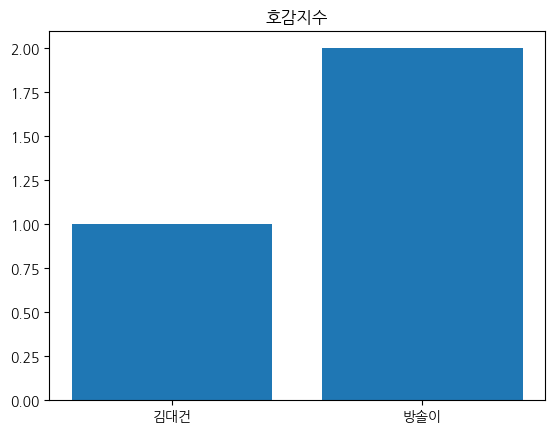

In [12]:
import matplotlib.pyplot as plt

plt.bar(['김대건','방솔이'],[1,2])
plt.title('호감지수')